## **Project Details**
# Goal: Visualize factors affecting trends in alcohol usage among students
This project will look at how alcohol consumption rates have changed over time among grade 8, 10, and 12 students. It uses data on the use of selected substances in the past 30 days among 8th, 10th, and 12th grade students from the CDC.

Available online at: https://data.cdc.gov/NCHS/DQS-Use-of-selected-substances-in-the-past-30-days/4kn2-jirk/about_data

The dataset categorizes data into three groups: grade level, grade level and sex, and grade level and race.
For this project, it will look at the intersection of age, sex, and race in influencing the prevalence of alcohol consumption among students.

In [53]:
# Import libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Attempt to retrieve dataset through the API provided by the CDC
data = None
url = "https://data.cdc.gov/resource/4kn2-jirk.json"
try:
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
except requests.exceptions.RequestException as error:
    print("Request failed: ", error)

df = pd.DataFrame(data)

df.head()

,topic,subtopic,subtopic_id,classification,classification_id,group,group_id,group_order,subgroup,subgroup_id,subgroup_order,estimate_type,estimate_type_id,time_period,time_period_id,flag,footnote_id_list,estimate
0,"Substance use among 8th, 10th, and 12th grade ...",Alcohol,1,Socioeconomic Characteristic,3,Grade level,1,1,8th grade,1.1,1,Percent of students,1,1980,1,- - -,"NA0004,FN0173,NT0111,SC0088,FN9998",NaN
1,"Substance use among 8th, 10th, and 12th grade ...",Alcohol,1,Socioeconomic Characteristic,3,Grade level,1,1,8th grade,1.1,1,Percent of students,1,1981,2,- - -,"NA0004,FN0173,NT0111,SC0088,FN9998",NaN
2,"Substance use among 8th, 10th, and 12th grade ...",Alcohol,1,Socioeconomic Characteristic,3,Grade level,1,1,8th grade,1.1,1,Percent of students,1,1982,3,- - -,"NA0004,FN0173,NT0111,SC0088,FN9998",NaN
3,"Substance use among 8th, 10th, and 12th grade ...",Alcohol,1,Socioeconomic Characteristic,3,Grade level,1,1,8th grade,1.1,1,Percent of students,1,1983,4,- - -,"NA0004,FN0173,NT0111,SC0088,FN9998",NaN
4,"Substance use among 8th, 10th, and 12th grade ...",Alcohol,1,Socioeconomic Characteristic,3,Grade level,1,1,8th grade,1.1,1,Percent of students,1,1984,5,- - -,"NA0004,FN0173,NT0111,SC0088,FN9998",NaN


In [54]:
# Check for missing data within each column
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, pct_missing))

topic - 0.0%
subtopic - 0.0%
subtopic_id - 0.0%
classification - 0.0%
classification_id - 0.0%
group - 0.0%
group_id - 0.0%
group_order - 0.0%
subgroup - 0.0%
subgroup_id - 0.0%
subgroup_order - 0.0%
estimate_type - 0.0%
estimate_type_id - 0.0%
time_period - 0.0%
time_period_id - 0.0%
flag - 0.804%
footnote_id_list - 0.0%
estimate - 0.196%


In [55]:
# Clean up and organize data
# First, remove columns not needed for this project and duplicates
df_dropped = df.drop(columns=['topic', 'classification', 'classification_id', 'subtopic_id', 'group_id', 'group_order', 'estimate_type', 'estimate_type_id', 'subgroup_order', 'flag', 'footnote_id_list', 'time_period_id']).drop_duplicates()

# Remove rows without an estimate value
df_dropped = df_dropped.dropna(subset=['estimate'])

# Change value type in time_period column from string to int
df_dropped.loc[:, 'time_period'] = df_dropped['time_period'].astype(int)
# Change value types in estimate column from string to float
df_dropped.loc[:, 'estimate'] = df_dropped['estimate'].astype(float)

# Filter data since project is focusing on alcohol usage among students of different grade levels over time
df_filtered = df_dropped[(df_dropped['subtopic'] == 'Alcohol') & (df_dropped['group'] == 'Grade level')]

# Sort data
df_filtered = df_filtered.sort_values(by=['subgroup_id', 'time_period'], ascending=[True, True])

# Group data based on the remapped subgroup_id column
grouped_df = df_filtered.groupby(by='subgroup_id')
grouped_df.head()  

,subtopic,group,subgroup,subgroup_id,time_period,estimate
11,Alcohol,Grade level,8th grade,1.1,1991,25.1
12,Alcohol,Grade level,8th grade,1.1,1992,26.1
13,Alcohol,Grade level,8th grade,1.1,1993,24.3
14,Alcohol,Grade level,8th grade,1.1,1994,25.5
15,Alcohol,Grade level,8th grade,1.1,1995,24.6
54,Alcohol,Grade level,10th grade,1.2,1991,42.8
58,Alcohol,Grade level,10th grade,1.2,1995,38.8
60,Alcohol,Grade level,10th grade,1.2,1997,40.1
61,Alcohol,Grade level,10th grade,1.2,1998,38.8
62,Alcohol,Grade level,10th grade,1.2,1999,40.0


In [56]:
# Check if there are any gaps in data for each grade through iteration
def check_for_gaps(g_df):
    for grade_id, info in g_df:
        grade = info['subgroup'].iloc[0]
    
        # Check for gaps in the years
        years = info['time_period'].tolist()
        gap_count = 0
        for i in range(1, len(years)):
            current_yr = years[i]
            past_yr = years[i-1]
            if current_yr != past_yr + 1:
                gap_count += 1
                if current_yr == past_yr + 2:
                    print(f'Gap in {past_yr + 1} for {grade}')
                else:
                    print(f'Gap between {past_yr+1} and {current_yr-1} for {grade}')
                
        if gap_count == 0:
            print(f'No gaps in data found for {grade}')

check_for_gaps(grouped_df)

No gaps in data found for 8th grade
Gap between 1992 and 1994 for 10th grade
Gap in 1996 for 10th grade
No gaps in data found for 12th grade


In [57]:
# 10th grade is missing data for 1992, 1993, 1994, and 1996. 8th grade only has data up to 1991. 
# Filter data again up until data is available for all three grades for consecutive years (1997)
df_filtered = df_filtered[df_filtered['time_period']>=1997]

# Sort data
df_filtered = df_filtered.sort_values(by=['subgroup_id', 'time_period'], ascending=[True, True])

# Regroup data 
grouped_df = df_filtered.groupby(by='subgroup_id')

# Check again for gaps
check_for_gaps(grouped_df)

No gaps in data found for 8th grade
No gaps in data found for 10th grade
No gaps in data found for 12th grade


In [58]:
# Let's see how much they have declined for each grade level since the earliest date recorded in the data.
def percent_change(g_df):
    total_amount = 0
    grade_num = 0
    
    for grade_id, info in g_df:
        grade = info['subgroup'].iloc[0]
        earliest_val = info['estimate'].iloc[0]
        latest_val = info['estimate'].iloc[-1]
        earliest_yr = info['time_period'].iloc[0]
        
        change_amount = np.round(((latest_val - earliest_val) / earliest_val) * 100, 2)
        total_amount += change_amount
        grade_num += 1

        if change_amount < 0:
            print(f'Alcohol use for {grade} students has decreased by {abs(change_amount)}% since {earliest_yr}')
        else:
            print(f'Alcohol use for {grade} students has increased by {change_amount}% since {earliest_yr}')
        
    total_amount /= grade_num
    total_amount = np.round(total_amount, 2)
    
    if change_amount < 0:
        print(f'Alcohol use for students has decreased by an average {abs(change_amount)}% since {earliest_yr}')
    else:
        print(f'Alcohol use for students has increased by an average {change_amount}% since {earliest_yr}')
        
percent_change(grouped_df)

Alcohol use for 8th grade students has decreased by 75.51% since 1997
Alcohol use for 10th grade students has decreased by 66.08% since 1997
Alcohol use for 12th grade students has decreased by 46.11% since 1997
Alcohol use for students has decreased by an average 46.11% since 1997


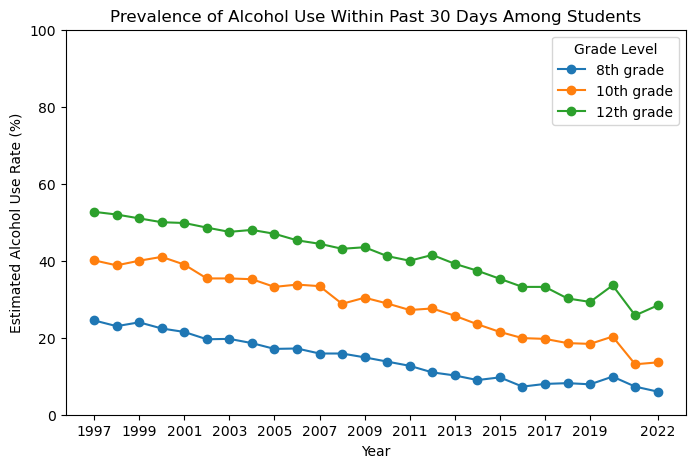

In [59]:
# With all the data now sorted and grouped, we can now visualize it using a line graph
# To illustrate trendlines for each grade, it's necessary to iterate through the grades and plot a line for each one
plt.figure(figsize=(8,5))
for grade, info in grouped_df:
    plt.plot(info['time_period'], info['estimate'], label=f'{info['subgroup'].iloc[0]}', marker='o')

# Formatting
plt.title("Prevalence of Alcohol Use Within Past 30 Days Among Students")
plt.xlabel("Year")
plt.ylabel("Estimated Alcohol Use Rate (%)")
plt.xticks([1997, 1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019, 2022])
plt.ylim(top=100, bottom=0)  # Ensure Y-axis starts at 0
plt.legend(title="Grade Level")

# Show the plot
plt.show()

# **Observation of overall trends in alcohol use between students of grades 8, 10, and 12**
This plot shows a general decline in alcohol use over time among students in grades 8, 10, and 12. This reflects how social attitudes have changed, with younger generations frequently being reported to drink alcohol less than older generations. However, there seems to have been a notable spike in alcohol use among students of all grade levels in 2020. This could have been caused by the initial social disruption caused from the onset of the COVID-19 pandemic. Due to how suddenly the pandemic spread and affected life for students, the sudden increase in loneliness, social anxiety, and depression may have led to an initial increase in alcohol consumption for students. However, since alcohol use immediately plummeted afterwards in 2021, it can be assumed that this spike will not impact on continuing decline in underaged drinking. The restrictions placed on social gatherings during the COVID-19 lockdowns could have influenced how quickly this spike declined within a year.

8th grade students have seen the most substantial decrease in alcohol consumption rates, which shows how younger generations are generally living life at a slower pace than older generations. Because of the growing prevalence of students choosing to focus on education up until and beyond adulthood compared to past decades, students are now less likely to try new experiences like trying alcoholic beverages. A major benefit of this development is that students are much less likely to have their body and brain development disrupted by the adoption of drinking habits. Research has demonstrated that early exposure to alcoholic beverages is a significant risk factor for alcohol abuse and substance use disorders.

In [61]:
# Now let's see how race influences alcohol consumption rates among students.
# First, apply a new filter for data according to grade level and race
df_filtered2 = df_dropped[(df_dropped['subtopic'] == 'Alcohol') & (df_dropped['group'] == 'Grade level and race')]

# To make it easier to identify each subgroup, let's create new columns with values based on the row's subgroup
# To do this, a new 'race' column will be created
dfc_filtered2 = df_filtered2.copy() # Create a copy to avoid overwriting previous values
dfc_filtered2[['grade', 'race']] = df_filtered2['subgroup'].str.split(': ', n=1, expand=True)
grouped_df2 = dfc_filtered2.groupby(by='subgroup_id')

# Check for gaps in data again
check_for_gaps(grouped_df2)

Gap in 2020 for 8th grade: Black
Gap in 2020 for 8th grade: White
Gap between 1992 and 1994 for 10th grade: Black
Gap in 1996 for 10th grade: Black
Gap in 2020 for 10th grade: Black
Gap between 1992 and 1994 for 10th grade: White
Gap in 1996 for 10th grade: White
Gap in 2020 for 10th grade: White
Gap in 2020 for 12th grade: Black
Gap in 2020 for 12th grade: White


In [62]:
# There seems to data missing for 1991-1995, 1996, and 2020, so let's filter the data again to between 1997 and 2019
dfc_filtered2 = dfc_filtered2[(dfc_filtered2['time_period']>=1997) & (dfc_filtered2['time_period']<=2019)]
grouped_df2 = dfc_filtered2.groupby(by='subgroup_id')
grouped_df2.head(1)

,subtopic,group,subgroup,subgroup_id,time_period,estimate,grade,race
146,Alcohol,Grade level and race,8th grade: Black,2.1,1997,16.9,8th grade,Black
188,Alcohol,Grade level and race,8th grade: White,2.2,1997,25.7,8th grade,White
230,Alcohol,Grade level and race,10th grade: Black,2.3,1997,26.2,10th grade,Black
272,Alcohol,Grade level and race,10th grade: White,2.4,1997,42.8,10th grade,White
314,Alcohol,Grade level and race,12th grade: Black,2.5,1997,33.1,12th grade,Black
356,Alcohol,Grade level and race,12th grade: White,2.6,1997,57.9,12th grade,White


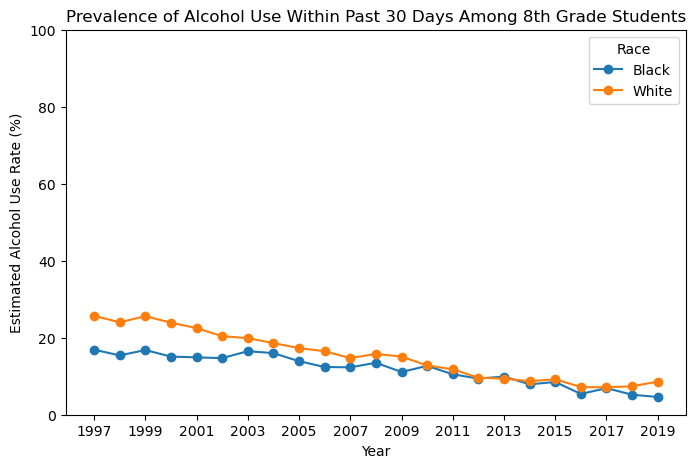

In [63]:
# This time, let's visualize differences between races in each grade level (starting with 8th grade students)
def create_graph(checkfrom, gradlevel: int, lbl: str):
    plt.figure(figsize=(8,5))
    for subgroup_id, info in checkfrom:
        grade = info['grade'].iloc[0]
        if grade == f'{gradlevel}th grade':
            plt.plot(info['time_period'], info['estimate'], label=f'{info[lbl].iloc[0]}', marker='o')
    
    # Formatting
    plt.title(f"Prevalence of Alcohol Use Within Past 30 Days Among {gradlevel}th Grade Students")
    plt.xlabel("Year")
    plt.ylabel("Estimated Alcohol Use Rate (%)")
    
    earliest_yr = info['time_period'].iloc[0]
    latest_yr = info['time_period'].iloc[-1]
    count_amount = int(np.floor((latest_yr-earliest_yr) / 2))+1
    years = [1997]
    for i in range(1, count_amount):
        years.append(years[i-1]+2)
    plt.xticks(years)
    
    plt.ylim(top=100, bottom=0)  # Ensure Y-axis starts at 0
    plt.legend(title=str.capitalize(lbl))
    plt.show()

create_graph(grouped_df2, 8, 'race')

It seems white students historically had higher rates of alcohol consumption, but this difference has greatly diminished in recent years. This could indicate that the socioeconomic differences which previously encouraged drinking among certain racial groups have since diminished.
Let's see if this trend is reflected in the other grade levels.

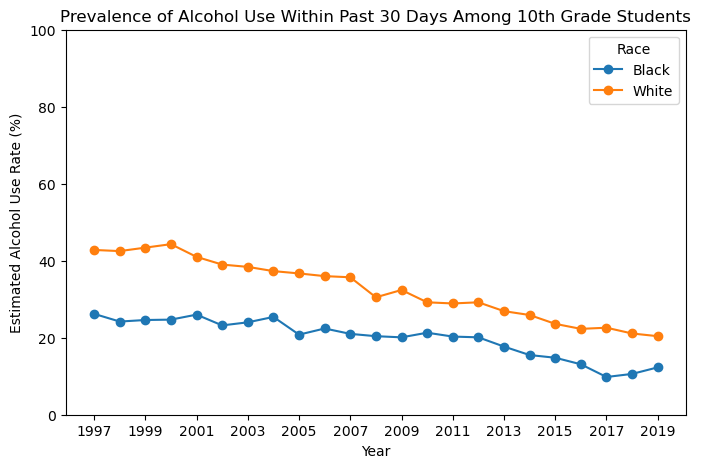

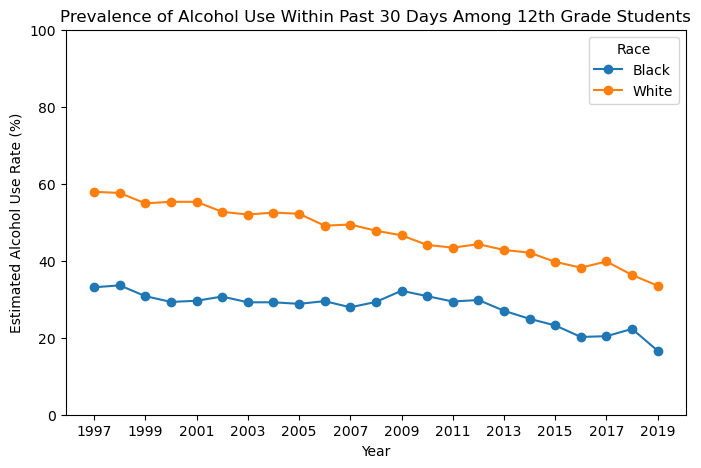

In [110]:
create_graph(grouped_df2, 10, 'race')

create_graph(grouped_df2, 12, 'race')

In [118]:
# Let's also look at the percentage decrease to see how much rates have decreased between White and Black students
percent_change(grouped_df2)

Alcohol use for 8th grade: Black students has decreased by 72.78% since 1997
Alcohol use for 8th grade: White students has decreased by 66.54% since 1997
Alcohol use for 10th grade: Black students has decreased by 53.05% since 1997
Alcohol use for 10th grade: White students has decreased by 52.34% since 1997
Alcohol use for 12th grade: Black students has decreased by 49.85% since 1997
Alcohol use for 12th grade: White students has decreased by 42.14% since 1997
Alcohol use for students has decreased by an average 42.14% since 1997


## **Observations of Differences in Underaged Drinking Rates between White and Black Students**
While all graphs show that White students consistently have higher rates of alcohol consumption than Black students, the difference in consumption rates between students of different races does not seem to be decreasing nearly as quickly for 10th and 12th grade students compared to 8th grade ones. The prevalence of underaged drinking for both White and Black students has declined by nearly half since 1997. Public health efforts to reduce underaged drinking should pay particular attention to how much more likely White students are to drink while underaged compared to other racial or ethnic groups. Rates of underaged drinking predictably increase with grade level (and therefore likely with age as well) for both White and Black students.

In [69]:
# Finally, let's look at if alcohol consumption rates differ between sexes
df_filtered3 = df_dropped[(df_dropped['subtopic'] == 'Alcohol') & (df_dropped['group'] == 'Grade level and sex')]
dfc_filtered3 = df_filtered3.copy() # Create a copy to avoid overwriting previous values
dfc_filtered3[['grade', 'sex']] = dfc_filtered3['subgroup'].str.split(': ', n=1, expand=True)
grouped_gdf = dfc_filtered3.groupby(by='subgroup_id')

# Check for gaps in data again
check_for_gaps(grouped_gdf)

Gap in 2020 for 8th grade: Female
Gap in 2020 for 8th grade: Male
Gap between 1992 and 1994 for 10th grade: Female
Gap in 1996 for 10th grade: Female
Gap in 2020 for 10th grade: Female
Gap between 1992 and 1994 for 10th grade: Male
Gap in 1996 for 10th grade: Male
Gap in 2020 for 10th grade: Male
Gap in 2020 for 12th grade: Female
Gap in 2020 for 12th grade: Male


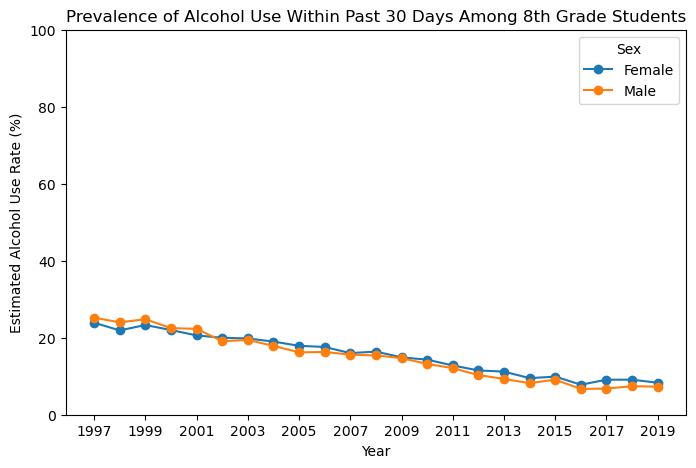

In [70]:
# There are gaps in 1992, 1993, 1994, 1996, and 2020 again, so let's filter it again to 1997-2019
dfc_filtered3 = dfc_filtered3[(dfc_filtered3['time_period']>=1997) & (dfc_filtered3['time_period']<=2019)]
grouped_gdf2 = dfc_filtered3.groupby(by='subgroup_id')

# Now let's graph the data awaitagain
create_graph(grouped_gdf2, 8, 'sex')

This graph is notable as it shows a slightly higher prevalence of alcohol consumption among female 8th grade students compared to male 8th grade students. 

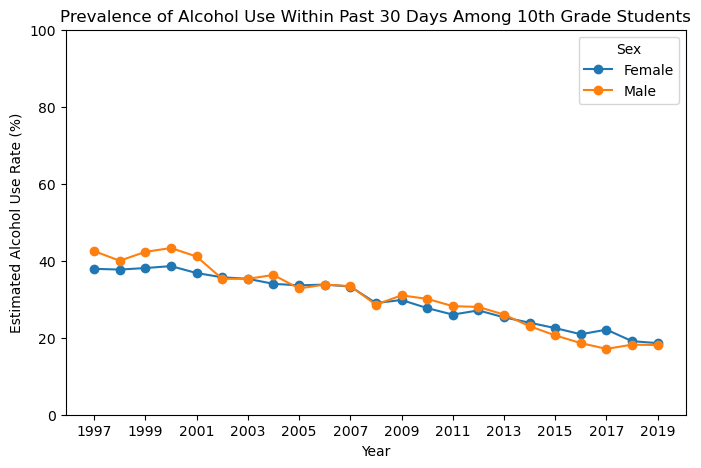

In [102]:
# Let's see if this trend continues with other grade levels.
create_graph(grouped_gdf2, 10, 'sex')

Compared to 8th grade students, the increased prevalence of alcohol consumption among female 10th grade students is relatively recent. Only in 2014 did the prevalence of alcohol use for female 10th grade students begin rising above the prevalence of for male 10th grade students.

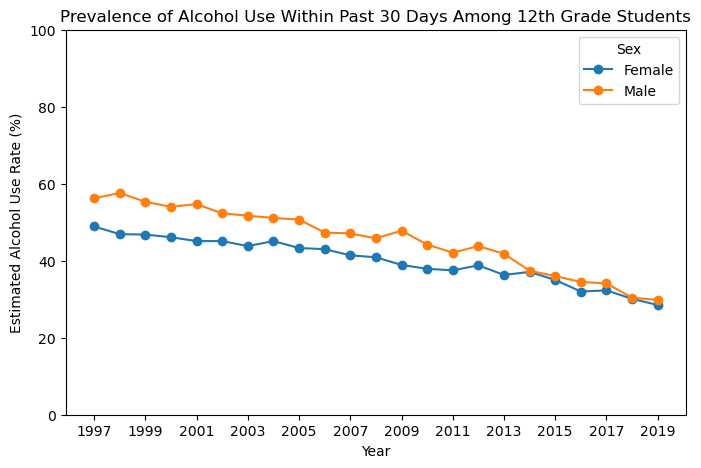

In [123]:
# Now, let's look at differences between sexes for 12th grade students.
create_graph(grouped_gdf2, 12, 'sex')

In [121]:
# Let's also look at how much drinking prevalence rates have decreased for both male and female students.
percent_change(grouped_gdf2)

Alcohol use for 8th grade: Female students has decreased by 65.27% since 1997
Alcohol use for 8th grade: Male students has decreased by 71.03% since 1997
Alcohol use for 10th grade: Female students has decreased by 50.92% since 1997
Alcohol use for 10th grade: Male students has decreased by 57.41% since 1997
Alcohol use for 12th grade: Female students has decreased by 41.72% since 1997
Alcohol use for 12th grade: Male students has decreased by 46.98% since 1997
Alcohol use for students has decreased by an average 46.98% since 1997


## **Observations of Differences in Underaged Drinking Prevalence between Male and Female Students**
The graph for 12th grade students is notably different compared to the ones for 8th and 10th grade students, as male 12th grade students have consistently had a higher rate of alcohol use compared to female 12th grade students. However, the gap between the prevalence between sexes for this group has also significantly decreased over time. In recent years, alcohol use rates between male and female 12th grade students has become nearly equivalent. This could reflect the evolution of gender roles in society, with social distinctions on the responsibilities of different gender roles continuing to diminish over time.

Research has been inconclusive on why this gap has drastically decreased over time, but it shows that female student populations may be more resistant to the overall decrease in underaged drinking. With factors like stress and anxiety affecting a growing number of students in recent years, female students may be particularly vulnerable to adopting drinking habits as a coping or stress mechanism. Self-esteem, peer-pressuring, or other behavioral factors could also encourage underaged drinking among female students. However, it is difficult to say what factors are most directly responsible. Nevertheless, overall prevalence has declined substantially among students of both sexes since 1997, regardless of grade level.

# **Project Summary and Findings**
Over time, the prevalence of alcohol consumption for 8th, 10th, and 12th grade students has decreased considerably. Previous gaps in consumption between students of different races and sexes has similarly diminished. This can be attributed to ongoing social developments, particularly with how younger generations are progressing through life at a slower pace and choosing to focus a larger part of their life in the education system. Changes in social roles can also be seen with how female and male students are now roughly equal in their likelihood of consuming alcohol. These changes reflect progress in discouraging underaged drinking. However, the prevalence of underaged drinking remains considerable among 12th grade students, regardless of race or sex. 
Attention should be made in public health campaigns to address the elevated prevalence of drinking among White students compared to other racial or ethnic groups. More research is needed to determine social and behavioral factors affecting the elevated likelihood of underaged drinking for 8th and 10th grade female students compared to male students. Educating students on how to overcome personal challenges without drinking factors, such as social encouragement, stress, anxiety, and environmental influences, can still greatly impact a student's likelihood of trying alcoholic beverages at an early age. 

## **Relevant Studies**
* https://www.cdc.gov/mmwr/volumes/72/su/su7201a10.htm 
* https://pmc.ncbi.nlm.nih.gov/articles/PMC4214145/
* https://pmc.ncbi.nlm.nih.gov/articles/PMC8992737/